In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
# autoreload   
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


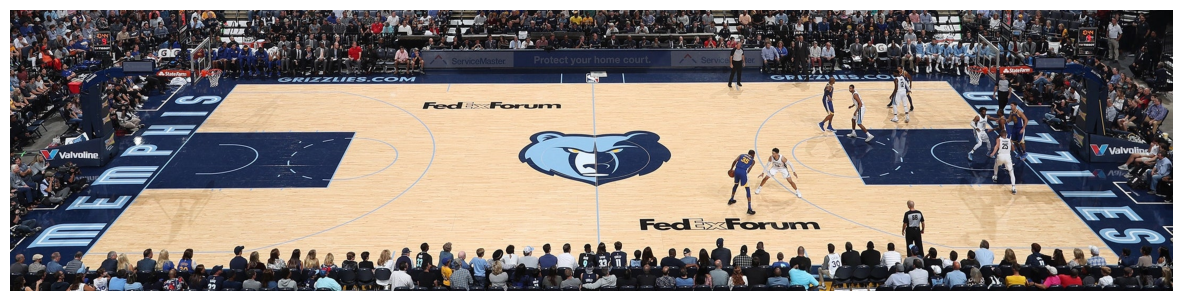

In [17]:
#Load the image
filename = 'memphis.jpeg'
img = cv2.imread(filename)
#Convert the image from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#plot the image
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.axis('off')
plt.show()

# Feature extraction
In this section three ellipses are extracted from the image

In [18]:
def plot_points(points, color='r', label=None):
    """
    Plot points on the image.
    """
    plt.scatter(points[:, 0], points[:, 1], c=color, marker='x', label=label, s=10, linewidths=.5)

### Point selection (manual)

In [19]:
if False:
    %matplotlib tk
    # Display the image and allow the user to select points interactively
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Select points of the first circle')

    def select_points(obj_name:str, color='r'):
        """
        Function to select points on the image.
        :param obj_name: Name of the object to select points for.
        :return: List of selected points.
        """
        plt.title(f'Select points for {obj_name}')
        print(f"Please select points for {obj_name} and press Enter when done.")
        points = plt.ginput(n=-1, timeout=0)  # n=-1 allows unlimited points, timeout=0 waits indefinitely
        print(f"Selected points for {obj_name}:", points)

        plot_points(np.array(points), color=color, label=obj_name)
        plt.legend()
        return points

    # Use ginput to select points
    points_C1 = select_points("Circle 1", color='r')
    points_C2 = select_points("Circle 2", color='g')
    points_C3 = select_points("Circle 3", color='b')

    plt.close()

    %matplotlib inline
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Selected Points')
    plot_points(np.array(points_C1), color='r', label='Circle 1')
    plot_points(np.array(points_C2), color='g', label='Circle 2')
    plot_points(np.array(points_C3), color='b', label='Circle 3')
    plt.legend()
    plt.show()

    #Save the points to a file
    with open(f'selected_points[{filename}].txt', 'w') as f:
        f.write("Circle 1:\n")
        for point in points_C1:
            f.write(f"{point[0]}, {point[1]}\n")
        f.write("\nCircle 2:\n")
        for point in points_C2:
            f.write(f"{point[0]}, {point[1]}\n")
        f.write("\nCircle 3:\n")
        for point in points_C3:
            f.write(f"{point[0]}, {point[1]}\n")

Loaded points for Circle 1: [[525.60483871 288.65009073]
 [564.02822581 257.61581653]
 [608.36290323 242.83759073]
 [686.6875     245.79323589]
 [728.06653226 284.21662298]
 [658.60887097 318.20654234]
 [569.93951613 318.20654234]]
Loaded points for Circle 2: [[1109.34475806  315.25089718]
 [1195.05846774  296.03920363]
 [1168.45766129  245.79323589]
 [1119.68951613  241.35976815]
 [1048.75403226  245.79323589]
 [1020.67540323  259.09363911]
 [1013.28629032  297.51702621]
 [1059.09879032  313.7730746 ]
 [1168.45766129  309.33960685]
 [1206.88104839  273.87186492]]
Loaded points for Circle 3: [[1477.32258065  267.9605746 ]
 [1523.13508065  241.35976815]
 [1653.18346774  254.66017137]
 [1678.30645161  270.91621976]
 [1679.78427419  297.51702621]
 [1650.22782258  310.81742944]
 [1610.3266129   316.72871976]
 [1534.95766129  307.86178427]]


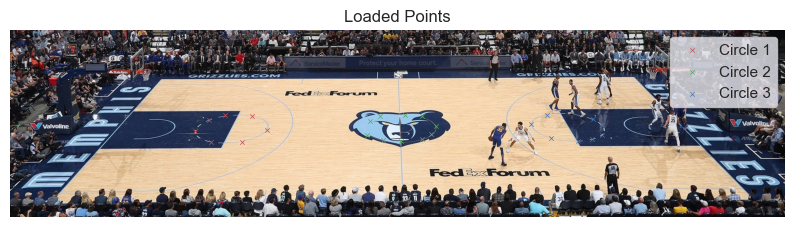

In [20]:
#Read points from the file
with open(f'selected_points[{filename}].txt', 'r') as f:
    lines = f.readlines()
    points_C1 = []
    points_C2 = []
    points_C3 = []
    current_circle = None

    for line in lines:
        line = line.strip()
        if line.startswith("Circle 1:"):
            current_circle = points_C1
        elif line.startswith("Circle 2:"):
            current_circle = points_C2
        elif line.startswith("Circle 3:"):
            current_circle = points_C3
        elif line and current_circle is not None:
            x, y = map(float, line.split(','))
            current_circle.append((x, y))

    points_C1 = np.array(points_C1)
    points_C2 = np.array(points_C2)
    points_C3 = np.array(points_C3)

# Print the loaded points
print("Loaded points for Circle 1:", points_C1)
print("Loaded points for Circle 2:", points_C2)
print("Loaded points for Circle 3:", points_C3)

# centerX = img.shape[1] // 2
# centerY = img.shape[0] // 2
# center = np.array([centerX, centerY])

# scale = 1

# # Center the points around the center of the image
# points_C1 = points_C1 - center
# points_C1 = points_C1 * scale

# points_C2 = points_C2 - center
# points_C2 = points_C2 * scale

# points_C3 = points_C3 - center
# points_C3 = points_C3 * scale

%matplotlib inline
#Plot the loaded points
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Loaded Points')
plot_points(points_C1, color='r', label='Circle 1')
plot_points(points_C2, color='g', label='Circle 2')
plot_points(points_C3, color='b', label='Circle 3')
plt.legend()
plt.show()

### Fit Ellipse to points

In [21]:
from HomoTopiContinuation.DataStructures.datastructures import Conic, Conics, Homography

In [22]:
def getConic(x0, y0, MA, ma, theta):
    a = MA / 2
    b = ma / 2
    theta_rad = np.deg2rad(theta)
    c, s = np.cos(theta_rad), np.sin(theta_rad)

    A = (c**2) / (a**2) + (s**2) / (b**2)
    B = 2 * c * s * (1/(a**2) - 1/(b**2))
    C = (s**2) / (a**2) + (c**2) / (b**2)
    D = -2*A*x0 - B*y0
    E = -2*C*y0 - B*x0
    F = A*x0**2 + B*x0*y0 + C*y0**2 - 1
    matrix = np.array([[A, B/2, D/2], [B/2, C, E/2], [D/2, E/2, F]])
    matrix /= matrix[0, 0]  # Normalize the matrix
    return Conic(matrix)

In [23]:
# Fit ellipses to the points using OpenCV
ellipse_C1 = cv2.fitEllipse(points_C1.astype(np.float32))
ellipse_C2 = cv2.fitEllipse(points_C2.astype(np.float32))
ellipse_C3 = cv2.fitEllipse(points_C3.astype(np.float32))

print("Ellipse parameters for Circle 1:", ellipse_C1)
print("Ellipse parameters for Circle 2:", ellipse_C2)
print("Ellipse parameters for Circle 3:", ellipse_C3)

#Convert the ellipses to matrix form
C1 = getConic(*ellipse_C1[0], *ellipse_C1[1], ellipse_C1[2])
C2 = getConic(*ellipse_C2[0], *ellipse_C2[1], ellipse_C2[2])
C3 = getConic(*ellipse_C3[0], *ellipse_C3[1], ellipse_C3[2])

print("Conic matrix for Circle 1:\n", C1.M)
print("Conic matrix for Circle 2:\n", C2.M)
print("Conic matrix for Circle 3:\n", C3.M)

Ellipse parameters for Circle 1: ((628.8209228515625, 281.9563903808594), (79.85284423828125, 203.53453063964844), 85.38331604003906)
Ellipse parameters for Circle 2: ((1105.541259765625, 278.341796875), (76.75096893310547, 207.02418518066406), 89.09537506103516)
Ellipse parameters for Circle 3: ((1581.559326171875, 277.31427001953125), (76.48589324951172, 208.52845764160156), 94.93865966796875)
Conic matrix for Circle 1:
 [[ 1.00000000e+00  4.25828478e-01 -7.48885984e+02]
 [ 4.25828478e-01  6.23895503e+00 -2.02688310e+03]
 [-7.48885984e+02 -2.02688310e+03  1.03240736e+06]]
Conic matrix for Circle 2:
 [[ 1.00000000e+00  9.89137540e-02 -1.13307309e+03]
 [ 9.89137540e-02  7.26276878e+00 -2.13088535e+03]
 [-1.13307309e+03 -2.13088535e+03  1.83507549e+06]]
Conic matrix for Circle 3:
 [[ 1.00000000e+00 -5.26651719e-01 -1.43551129e+03]
 [-5.26651719e-01  7.04929412e+00 -1.12193892e+03]
 [-1.43551129e+03 -1.12193892e+03  2.57109963e+06]]


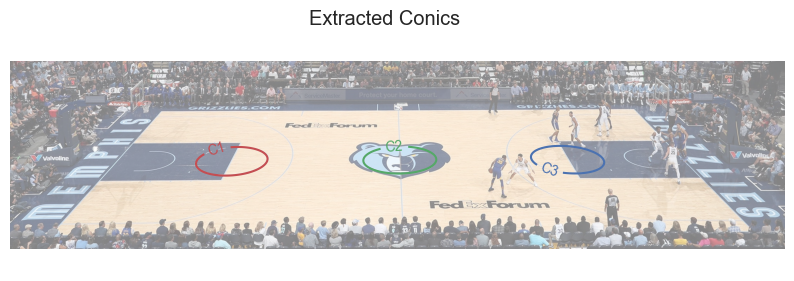

In [24]:
from HomoTopiContinuation.Plotter.Plotter import Plotter
plotter = Plotter(1, 1, title = "Extracted Conics", figsize=(10, 3))
plotter.newAxis(axisSame=False)
plotter.getCurrentAxis().imshow(img, alpha=0.5)
plotter.getCurrentAxis().axis('off')
plotter.getCurrentAxis().grid(False)
plotter.plotConic2D(C1, color='r', conicName="C1")
plotter.plotConic2D(C2, color='g', conicName="C2")
plotter.plotConic2D(C3, color='b', conicName="C3")
plotter.show()

# Rectification

  0%|          | 0/3000 [00:00<?, ?it/s]

Early stopping at iteration 1854 with loss 0.0015378021635115147


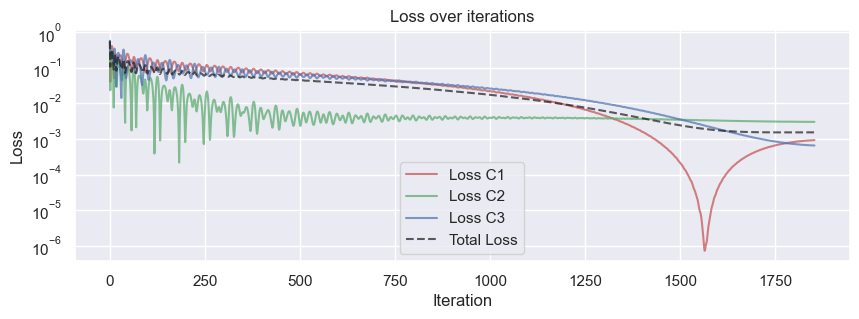

In [92]:
from HomoTopiContinuation.Rectifier.homotopyc_rectifier import HomotopyContinuationRectifier
from HomoTopiContinuation.Rectifier.numeric_rectifier import NumericRectifier
from HomoTopiContinuation.Rectifier.GDRectifier import GDRectifier
import jax.numpy as jnp

rectifier = GDRectifier
C1.M = C1.M / C1.M[2, 2]  # Normalize the conic matrix
C2.M = C2.M / C2.M[2, 2]  # Normalize the conic matrix
C3.M = C3.M / C3.M[2, 2]  # Normalize the conic matrix
H, history, losses, grads, ms, vs = rectifier.rectify(Conics(C1, C2, C3), alpha=1e-3, iterations=3000, beta1=.99, beta2=.999, weights=jnp.array([1.0, 1.0, 1.0]))

# Plot the losses
plt.figure(figsize=(10, 3))
plt.semilogy(losses[:, 0], label='Loss C1', color='r', alpha=0.7)
plt.semilogy(losses[:, 1], label='Loss C2', color='g', alpha=0.7)
plt.semilogy(losses[:, 2], label='Loss C3', color='b', alpha=0.7)
plt.semilogy(losses[:, 3], label='Total Loss', color='k', linestyle='--', alpha=0.7)
plt.title('Loss over iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

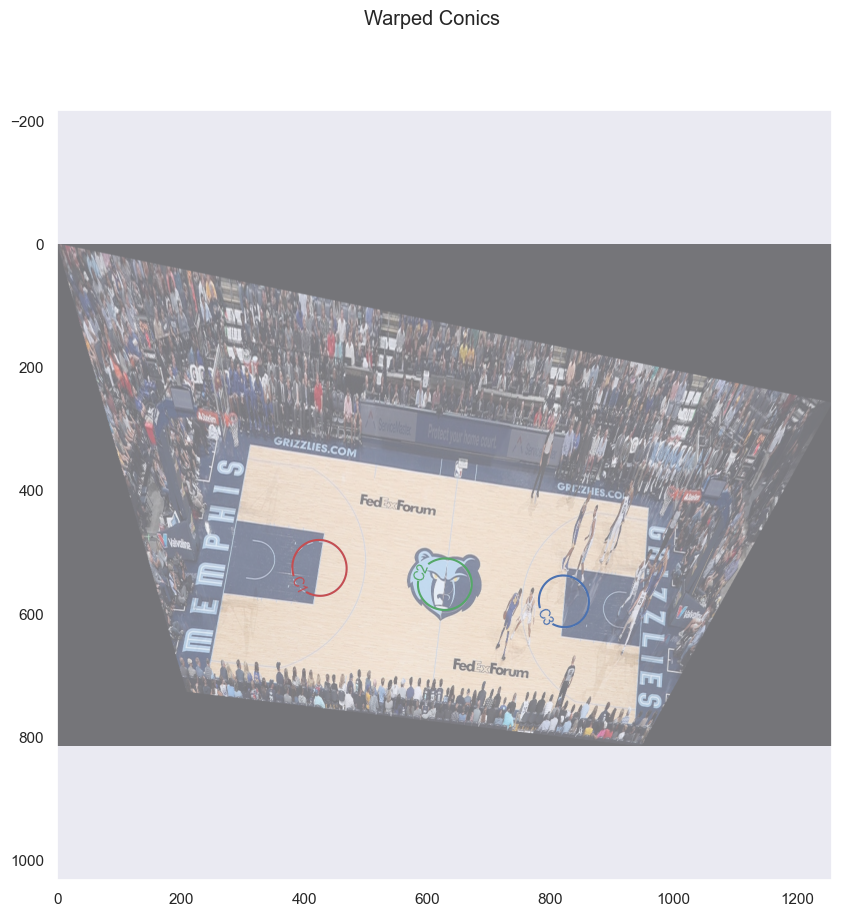

In [79]:
from HomoTopiContinuation.ImageWarper.ImageWarper import ImageWarper
warper = ImageWarper()
warped_img, adjH = ImageWarper()(img, H)
centerX_warped = warped_img.shape[1] // 2
centerY_warped = warped_img.shape[0] // 2
adjH = Homography(adjH)
# Rectify the conics using the homography
C1_warped = C1.applyHomography(adjH)
C2_warped = C2.applyHomography(adjH)
C3_warped = C3.applyHomography(adjH)

plotter = Plotter(1, 1, title = "Warped Conics", figsize=(10, 10))

plotter.newAxis(axisSame=True)
ax = plotter.getCurrentAxis()
ax.grid(False)
ax.imshow(warped_img, alpha=0.5)
plotter.plotConic2D(C1_warped, color='r', conicName="C1")
plotter.plotConic2D(C2_warped, color='g', conicName="C2")
plotter.plotConic2D(C3_warped, color='b', conicName="C3")

plotter.show()


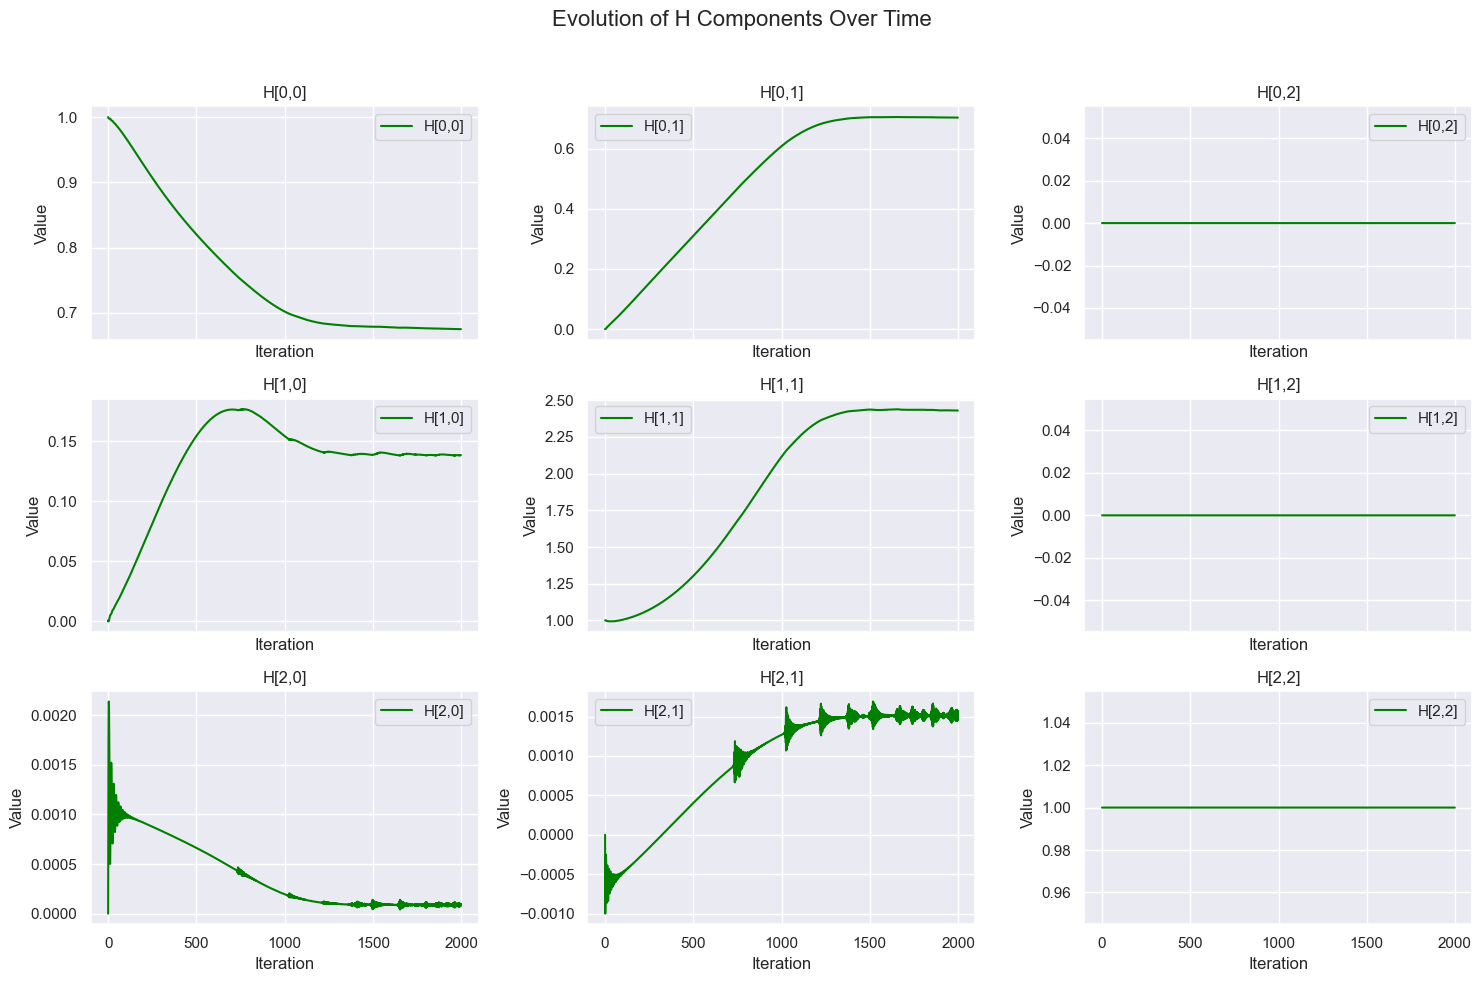

In [80]:
# Plot the evolution of each component of the 3x3 H matrix over time in a 3x3 grid

# Convert the list of Homography objects in history to a numpy array of shape (steps, 3, 3)
H_arr = np.array([h.H for h in history])  # shape: (steps, 3, 3)

fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
fig.suptitle("Evolution of H Components Over Time", fontsize=16)

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.plot(H_arr[:, i, j], label=f'H[{i},{j}]', color='green')
        ax.set_title(f"H[{i},{j}]")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Value")
        ax.grid(True)
        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

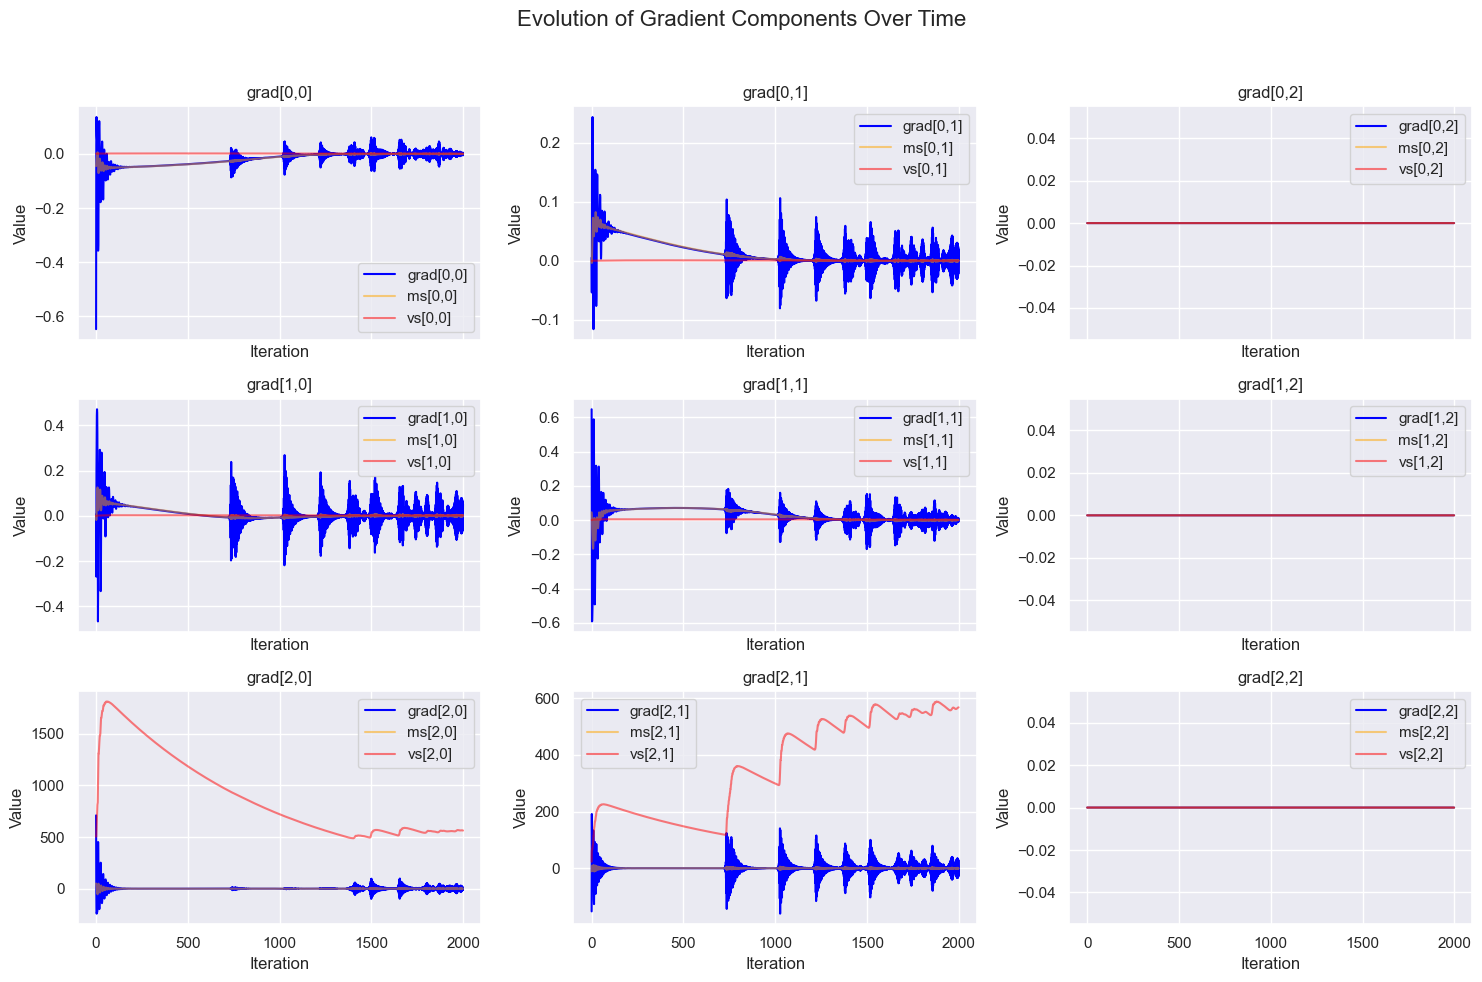

In [81]:
# Plot the evolution of each component of the 3x3 gradient matrix over time in a 3x3 grid

fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
fig.suptitle("Evolution of Gradient Components Over Time", fontsize=16)

# grads is assumed to be a list of 3x3 matrices (e.g., jax.numpy arrays or numpy arrays)
grads_arr = np.array(grads)  # shape: (steps, 3, 3)

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.plot(grads_arr[:, i, j], label=f'grad[{i},{j}]', color='blue')
        ax.plot(ms[:, i, j], label=f'ms[{i},{j}]', color='orange', alpha=0.5)
        ax.plot(vs[:, i, j], label=f'vs[{i},{j}]', color='red', alpha=0.5)
        ax.legend()
        ax.set_title(f"grad[{i},{j}]")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Value")
        ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [82]:
from HomoTopiContinuation.Losser.CircleLosser import CircleLosser

CircleLosser.computeCircleLoss(None, Conics(C1_warped, C2_warped, C3_warped))

[np.float64(0.2652949380810673),
 np.float64(0.29451447976732475),
 np.float64(0.28768463205752165)]

In [83]:
from tqdm import tqdm

import cv2

SAVEVIDEO = True  # Set to True to save the video, False to skip
if SAVEVIDEO:
    video_frames = []
    video_size = None
    startupPeriod = 0
    period = 100  # Plot every 100 steps
    firstPeriod = False

    for idx, H_step in enumerate(tqdm(history, desc="Generating frames")):
        if firstPeriod and (idx % period != 0 and idx != len(history) - 1):
            continue  # Skip frames except every 'period' and the last one

        firstPeriod = idx >= startupPeriod

        warped_img_step, adjH_step = warper(img, H_step)
        adjH_step = Homography(adjH_step)
        C1_warped_step = C1.applyHomography(adjH_step)
        C2_warped_step = C2.applyHomography(adjH_step)
        C3_warped_step = C3.applyHomography(adjH_step)

        plotter = Plotter(1, 1, title = f"Warped Conics step #{idx}", figsize=(10, 10))

        plotter.newAxis(axisSame=True)
        ax = plotter.getCurrentAxis()
        ax.grid(False)
        ax.imshow(warped_img_step, alpha=0.5)
        plotter.plotConic2D(C1_warped_step, color='r', conicName="C1")
        plotter.plotConic2D(C2_warped_step, color='g', conicName="C2")
        plotter.plotConic2D(C3_warped_step, color='b', conicName="C3")

        fig = plotter.figure
        fig.canvas.draw()

        # Convert plot to image
        frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frame = frame[..., :3]  # Drop alpha channel to get RGB
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)

        if video_size is None:
            video_size = (frame.shape[1], frame.shape[0])
        video_frames.append(frame)

    # Save video
    out = cv2.VideoWriter('rectification_history.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, video_size)
    for frame in video_frames:
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    out.release()
    print(f"Video saved as rectification_history.mp4")

Generating frames: 100%|██████████| 2000/2000 [00:01<00:00, 1038.52it/s]


Video saved as rectification_history.mp4
